In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import torch
import pandas as pd
from wrapers import *
from torch_geometric.data import InMemoryDataset, DataLoader
from torch_geometric import data as DATA
import os
from wrapers import GATNet_augmented

In [3]:
model = GATNet_augmented()
model.load_state_dict(torch.load("../GraphDTA/model_GATNet_davis.model", map_location=torch.device('cpu'), weights_only=True))

<All keys matched successfully>

In [4]:
data_source = pd.read_csv('../GraphDTA/data/davis_test.csv')

In [5]:
iso_smiles, smiles_id_dict, smiles_graphs = smiles_to_graphs(data_source.index.values,
                                                             data_source["compound_iso_smiles"].values,
                                                             isomericSmiles=True,
                                                             use_rdkit=True)

In [6]:
from torch.utils.data.dataloader import DataLoader
dataset = CompoundsStream(iso_smiles, smiles_graphs, smiles_id_dict)
embedding_loader = DataLoader(dataset=dataset, batch_size = 1)

In [7]:
model.eval()
embedded_mols = []
with torch.no_grad():
    for data in embedding_loader:
        #print(data.x[0], model2.g_embedding(data.x[0]))        
        m = model.g_embedding(data)
        embedded_mols.append(m)

/home/roozbeh/Desktop/comp-bio/task1/notebooks/wrapers.py:343: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  yield torch.Tensor(features), torch.LongTensor(np.array(edge_index)).transpose(1, 0), id


In [8]:
len(embedded_mols), data_source.shape, data_source.shape[0] - len(embedded_mols), data_source.shape[0]-len(iso_smiles), len(iso_smiles)

(5010, (5010, 3), 0, 0, 5010)

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [10]:
def plot_tSNE(embedded_data, ids, 
              n_iter=300, figsize=(10,10), 
              verbose=1, hue_callback=None, 
              fig=None, ax=None,
              title=""):
    tsne = TSNE(n_components=2, verbose=verbose, perplexity=40, n_iter=n_iter)
    tsne_results = tsne.fit_transform(embedded_data)
    df = pd.DataFrame({})
    df['X'] = tsne_results[:,0]
    df['Y'] = tsne_results[:,1]
    df['id'] = ids
    #
    if hue_callback is not None:
        df["target"] = hue_callback(df, embedded_data, ids)
    #
    #
    np.random.seed(42)    
    rndperm = np.random.permutation(df.shape[0])
    #
    if ax is None and fig is None:
        fig = plt.figure(figsize=figsize)

    if ax is None:
        ax = fig.subplots()    
    sns.scatterplot(
        x="X", y="Y",
        hue= None if hue_callback is None else "target",
        palette=sns.color_palette("Set1", 100),
        data=df.loc[rndperm,:],
        legend="full",
        alpha=0.3,
        ax=ax
    )
    ax.set_title(title)
    return ax, df

/home/roozbeh/Desktop/comp-bio/task1/.venv_graphdta/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipykernel_3132737/3483545894.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


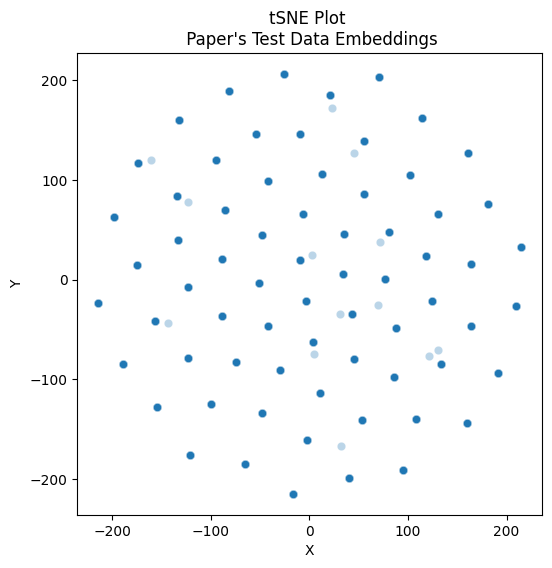

In [11]:
arr_embedded_mols = np.array([ item[0].numpy().reshape(-1) for item in embedded_mols ])
ids = [ str(item[1][0]) for item in embedded_mols ]                             
_, df_tSNE = plot_tSNE(arr_embedded_mols, ids, figsize=(6,6), n_iter=1000, verbose=0, title="tSNE Plot \n Paper's Test Data Embeddings")